<left>
<img src="idc_logo.png" width=100 align="left">
</left>

<H4>Advanced Stats. for Data Science (Spring 2022)</H4>

<H1>Examples from Lecture 12 </H1>

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import scipy
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

np.random.seed(2021)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 18})
%matplotlib inline

In [188]:
def load_house_prices_data(path = "housing_prices.csv", vars_to_add = []):
    """
    Args:
    -----
    path:  path to csv file
    
    Load and clean house prices data:
        filters for numeric predictors only
        filters for small lots only
        renames varaibles so that all variable names begins with [a-z]
        
    """
    
    
    def detect_outliers(df, q=0.01):
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1-q)
        return lower_outliers | upper_outliers
    
    data_raw = pd.read_csv(path)
    data1 = data_raw[data_raw.LotArea < 15000]  # focus on small lots
    data1 = data1.rename( # stats model formula cannot have
        # covaraite names starting with non letter
        columns = {'1stFlrSF': 'FirstFlrSF',
                   '2ndFlrSF': 'SecondFlrSF'}) 
                                                              
    variables =[
        'SalePrice',
        'LotArea', 
        'YearBuilt',
         'YrSold', 'MoSold', 
         'Fireplaces', 
        'GarageCars', 'ScreenPorch', 
         'HalfBath', 'FullBath',
         'GrLivArea', 
         'BedroomAbvGr',
        'FirstFlrSF', 
        'SecondFlrSF',
        'TotRmsAbvGrd',
        'LowQualFinSF', 'TotalBsmtSF',
        'LotFrontage', 'WoodDeckSF',
         'OverallQual',
         'OverallCond'
    ] + vars_to_add

    data1 = data1.filter(variables).dropna()
    
    #mask = detect_outliers(data1, .01).any(1)
    #print(f"Masked a fraction of {mask.mean()} of the data due to outliers")
    return data1#[~mask]


# Outliers

In [189]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm



def find_outliers(data, target, thresh=3):
    
    def cv(resid, Z):
        # Find outliers using CV:
        H = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
        h = np.diag(H)
        return np.sum(resid ** 2 / (1 - h))


    CVerr = []
    for i in tqdm(range(len(data))):
        d_i = data.iloc[i:i+1]
        data_minus_i = data.drop(d_i.index)

        y = data_minus_i[target]
        data_vars = data_minus_i.drop(target, axis=1)

        model = sm.OLS(y, data_vars).fit()

        eps_i = np.mean(d_i[target] - model.predict(d_i.drop(target, axis=1)))
        CVerr += [eps_i / np.sqrt(model.mse_resid)]


    resid_cv = np.array(CVerr)
    suspected_outliers = np.abs(resid_cv) > thresh
    return suspected_outliers


def remove_outliers(data, target):    
    suspected_outliers = find_outliers(data, target)
    print(f"Fraction of outliers removed is {np.mean(suspected_outliers)}")
    return data.iloc[~suspected_outliers]


In [190]:
data = load_house_prices_data()
data_wo_outliers = remove_outliers(data, 'SalePrice')

100%|██████████| 1120/1120 [00:19<00:00, 57.92it/s]

Fraction of outliers removed is 0.013392857142857142


# Heteroscedasticity

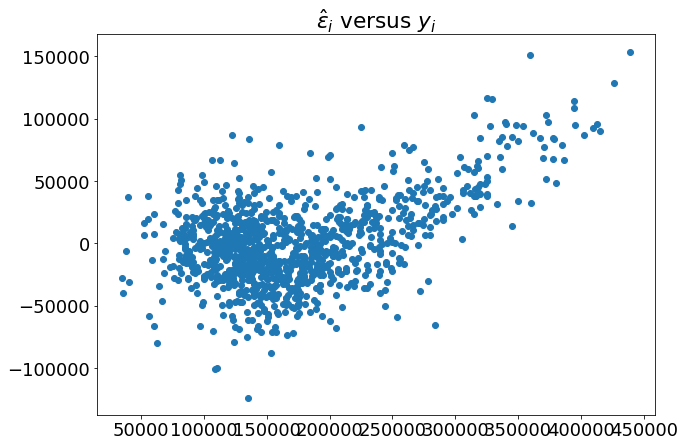

In [191]:
data = data_wo_outliers.copy()

target = 'SalePrice' 
lo_predictors = ['const', 'LotArea',  'YearBuilt',
    'GarageCars', 'YrSold', 'MoSold', 'Fireplaces',
    'HalfBath', 'LowQualFinSF', 'TotalBsmtSF',
    '1stFlrSF', 'LotFrontage', 'ScreenPorch',
     'WoodDeckSF', 'OverallCond', 'BsmtUnfSF']

data.loc[:, 'const'] = 1

data_predictors = data.filter(lo_predictors, axis=1)

Z = data_predictors.values
y = data[target]

model = sm.OLS(y, Z).fit()

plt.scatter(y, model.resid)
plt.title("$\hat{\epsilon}_i$ versus $y_i$")
plt.show()


It appears that the residuals' variance gets larger the larger $y$ we try to predcit (more difficult to predict more expensive houses); this phenomena is called overdispersion. A transformation may stabilize the variance. Another option is to build two models: one for expensive houses and another for less expansive ones, or find another predictor that can help explain the difference. 

Taking a log transform to stabilize the variance:

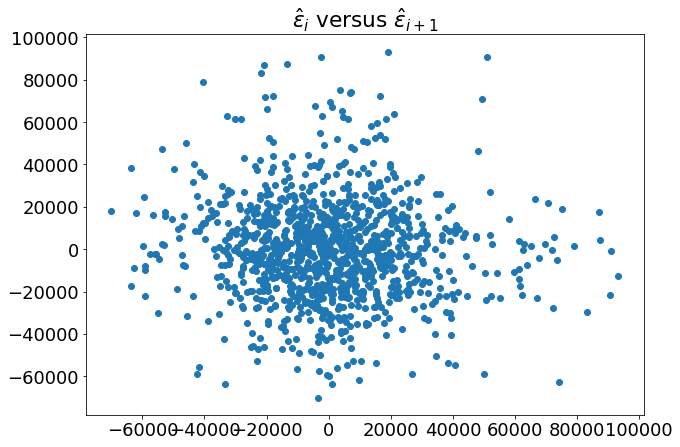

In [192]:
data = data_wo_outliers.copy()

var_data = data.drop(['SalePrice'], axis=1)
#var_data['ses_cos'] = np.cos(2*np.pi * data['MoSold'] / 12)
#var_data['ses_sin'] = np.sin(2*np.pi * data['MoSold'] / 12)

X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = data['SalePrice']

model = sm.OLS(y, Z).fit()

plt.scatter(model.resid[:-1], model.resid[1:])
plt.title("$\hat{\epsilon}_i$ versus $\hat{\epsilon}_{i+1}$")
plt.show()


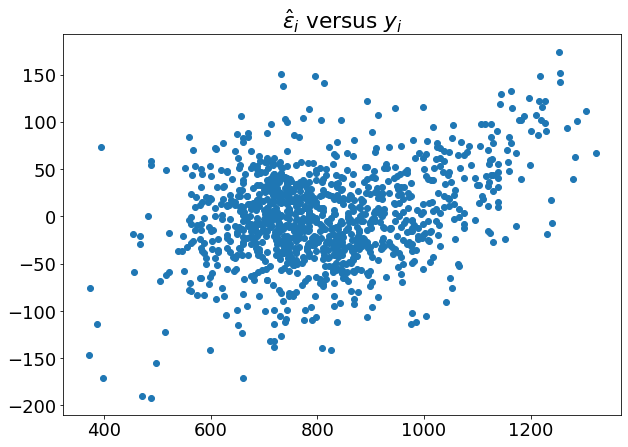

In [193]:
data = data_wo_outliers.copy()

var_data = data.drop(['SalePrice'], axis=1)
#var_data['ses_cos'] = np.cos(2*np.pi * data['MoSold'] / 12)
#var_data['ses_sin'] = np.sin(2*np.pi * data['MoSold'] / 12)

X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)

def box_cox(x, lmd):
    return ( x ** lmd - 1 ) / lmd

y =  box_cox(data['SalePrice'], lmd=0.5)

model = sm.OLS(y, Z).fit()

plt.scatter(y, model.resid)
plt.title("$\hat{\epsilon}_i$ versus $y_i$")
plt.show()


## Correlation in the residulas

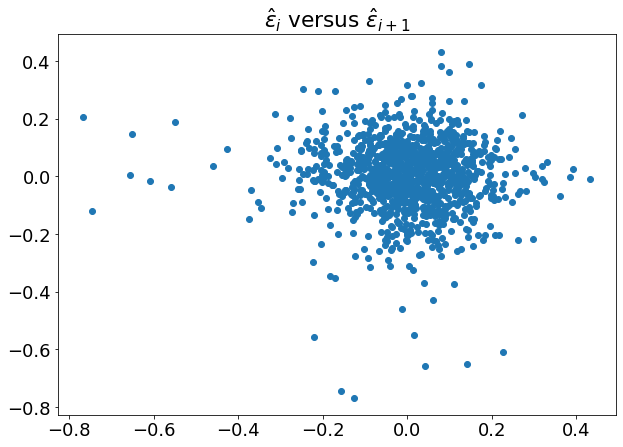

In [194]:
data = data_wo_outliers.copy()
var_data = data.drop(['SalePrice'], axis=1)
#var_data['ses_cos'] = np.cos(2*np.pi * data['MoSold'] / 12)
#var_data['ses_sin'] = np.sin(2*np.pi * data['MoSold'] / 12)

X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = np.log(1 + data['SalePrice'])


model = sm.OLS(y, Z).fit()

plt.scatter(model.resid[:-1], model.resid[1:])
plt.title("$\hat{\epsilon}_i$ versus $\hat{\epsilon}_{i+1}$")
plt.show()


Uncorrelatedness assumption seems to be reasonable. This makes sense becasue the nature of the data.

# Logistic Regression

In [145]:
data = load_house_prices_data()
mask = find_outliers(data, 'SalePrice')

100%|██████████| 1120/1120 [00:12<00:00, 91.62it/s]


### We will predict whether a house contains a fireplace or not

In [186]:
data_woo = data[~mask]

data_woo.loc[:, 'Fireplaces'] = data_woo['Fireplaces'] > 0 + 0.0

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

target = 'Fireplaces'
n_splits = 10

clf = LogisticRegression(max_iter=1000, penalty='l2', solver ='lbfgs')


acc = []
for train_idx, val_idx in KFold(n_splits=n_splits).split(data_woo):
    
    Xtrain = data_woo.iloc[train_idx].drop(target, axis=1)
    ytrain = data_woo.iloc[train_idx][target]
    clf.fit(X = Xtrain, y = ytrain)
    
    Xval = data_woo.iloc[val_idx].drop(target, axis=1)
    yval = data_woo.iloc[val_idx][target]

    acc += [clf.score(Xval, yval)]
    
print(f"Accuracy averaged over {n_splits} CV splits is {np.mean(acc)} ({np.std(acc)})")

Accuracy averaged over 10 CV splits is 0.7248484848484849 (0.03314080919259168)
